In [1]:
import os
import scanpy as sc
import anndata as ad
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
from scipy.sparse import vstack, hstack
from collections import deque

# read in data

In [ ]:
mtx_path = '/public21/home/sc90258/huangying/analysis/12.pan_mosquito/20241225_rerun_mtx-stand_by/3.cxpip/2.mtx/shell/cxpip/outs/filtered'
adata = sc.read_10x_mtx(mtx_path)

adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 11742 × 19673
    var: 'gene_ids'

In [7]:
adata.var_names

Index(['LOC120427725', 'LOC120427726', 'LOC128092783', 'LOC120427727',
       'LOC120427724', 'LOC120422531', 'LOC120422536', 'LOC120422525',
       'LOC120422524', 'LOC120422535',
       ...
       'ATP8', 'ATP6', 'COX3', 'ND3', 'ND5', 'ND4', 'ND4L', 'ND6', 'CYTB',
       'ND1'],
      dtype='object', length=19673)

# QC

## mark mitochondrial genes

In [8]:
# mitochondrial genes
mt_genes = ('ATP6', 'ATP8', 'COX1', 'COX2', 'COX3', 'CYTB', 'ND1', 'ND2', 'ND3', 'ND4', 'ND4L', 'ND5', 'ND6')

adata.var["mt"] = adata.var_names.map(lambda x: str(x) in mt_genes)

## calculate QC metrics

In [9]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 11742 × 19673
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [10]:
adata.obs['pct_counts_mt'].median()

np.float32(3.506372)

## plot QC plot before do filtering 

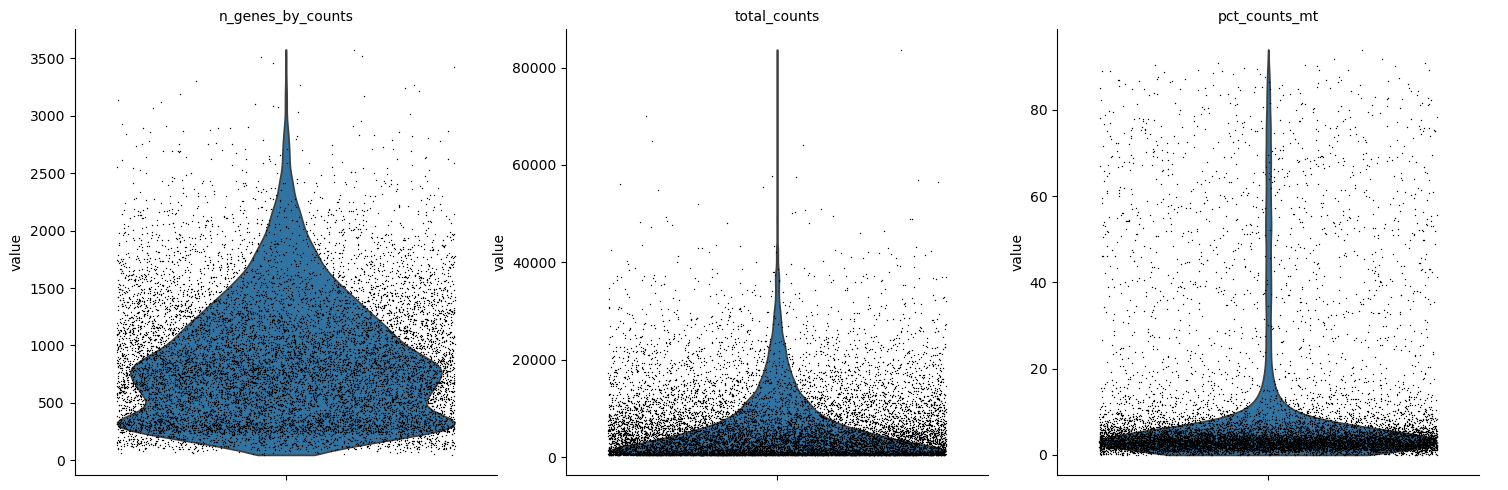

In [11]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

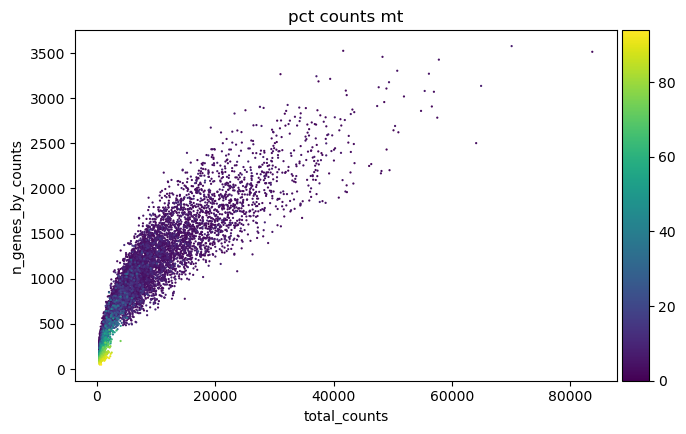

In [12]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## plot QC plot after do filtering 

In [13]:
# maximum percent.mt
max_percent_mt = 15

adata.obs["mt_outlier"] = (
    adata.obs["pct_counts_mt"] > max_percent_mt
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    10360
True      1382
Name: count, dtype: int64

In [14]:
# QC thresholds
min_n_genes_by_counts = 100
# maximum nFeature_RNA
max_n_genes_by_counts = 2500


adata.obs["genes_outlier"] = \
    (adata.obs.n_genes_by_counts < min_n_genes_by_counts) | \
    (adata.obs.n_genes_by_counts > max_n_genes_by_counts)
adata.obs.genes_outlier.value_counts()

genes_outlier
False    11573
True       169
Name: count, dtype: int64

In [15]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[
    (~adata.obs.mt_outlier) & \
    (~adata.obs.genes_outlier)
].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 11742
Number of cells after filtering of low quality cells: 10258


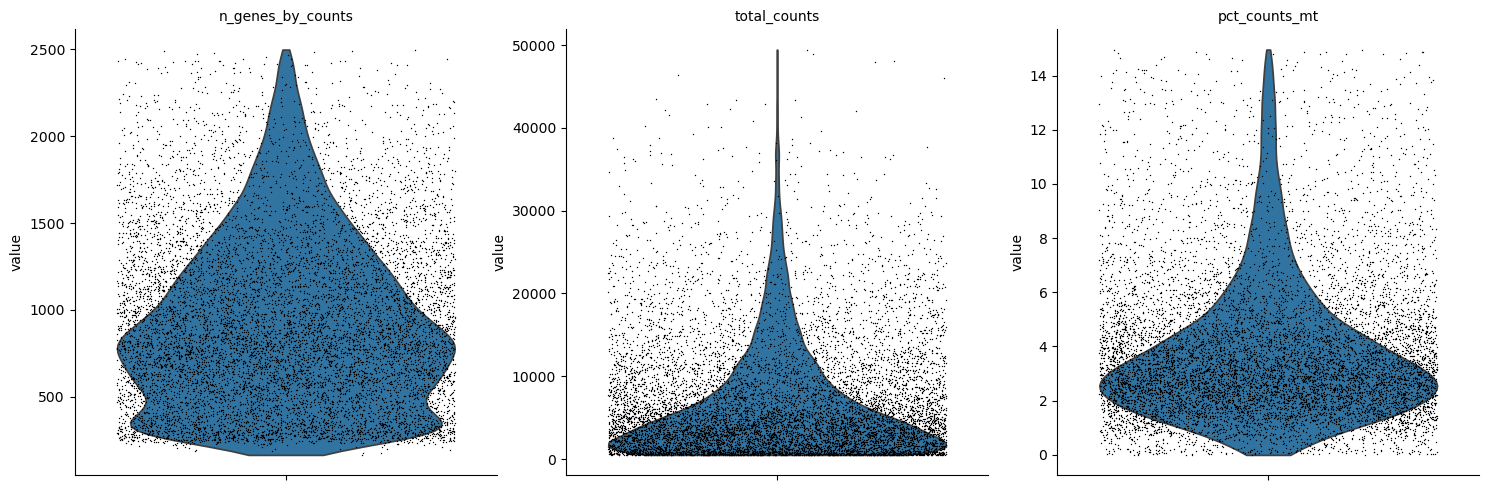

In [16]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

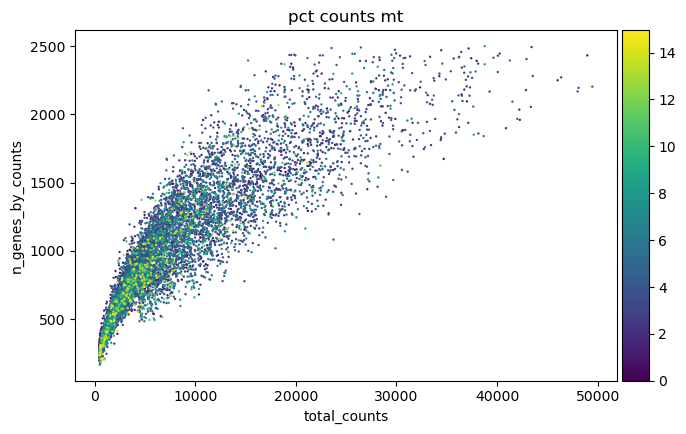

In [17]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [18]:
adata.obs.n_genes_by_counts.median()

np.float64(843.0)

In [19]:
adata.obs.total_counts.median()

np.float32(4582.0)

## write QC data for doublets check

In [22]:
Rscript = """library(dplyr)
library(Seurat)
library(ggplot2)
library(future)
library(Cairo)
library(DoubletFinder)
library(Matrix)
library(SeuratDisk)

args <- commandArgs(trailingOnly = TRUE)

## read in file --------------------------------------------------------
# path to 10x directory
ipath = args[1]
# 'project' in 'CreateSeuratObject'
project = 'midgut'
# read in file
data10x = Read10X(
    data.dir = ipath
)
# make Seurat object of RNA data
# create Seurat object
seurat_obj =  CreateSeuratObject(
    counts = data10x, 
    assay = "RNA",
    project = project, 
    min.cells = 3
)
## do normalization --------------------------------------------------------
seurat_obj <- NormalizeData(seurat_obj, normalization.method = "LogNormalize", scale.factor = 10000)
# feature selection
# Identification of highly variable features
seurat_obj <- FindVariableFeatures(seurat_obj, selection.method = "vst", nfeatures = 2000)
# scaling data
all.genes <- rownames(seurat_obj)
seurat_obj <- ScaleData(seurat_obj, features = all.genes)

## PCA reduce dimension ----------------------------------------------------
seurat_obj <- RunPCA(seurat_obj, features = VariableFeatures(object = seurat_obj))
# runUMAP
seurat_obj <- RunUMAP(seurat_obj, dims = 1:50)

# https://cloud.tencent.com/developer/article/1825672
nExp <- round(ncol(seurat_obj) * 0.04)  # expect 4% doublets
data.filt <- doubletFinder_v3(
    seurat_obj, 
    pN = 0.25, # https://cloud.tencent.com/developer/article/1825672
    pK = 0.09, 
    nExp = nExp, 
    PCs = 1:50)

DF.name = colnames(data.filt@meta.data)[grepl("DF.classification", colnames(data.filt@meta.data))]

DimPlot(data.filt, group.by = DF.name)

# save seurat_obj
opath_seurat_obj = './mark_doublet/mark_doublet.seurat_obj.rds'
saveRDS(data.filt, file = opath_seurat_obj)
# write h5ad file
SaveH5Seurat(data.filt, filename = "./mark_doublet/mark_doublet.seurat_obj.h5Seurat")
Convert("./mark_doublet/mark_doublet.seurat_obj.h5Seurat", dest = "h5ad")
"""

In [23]:
os.mkdir('./mark_doublet')
with open('./mark_doublet/DoubletFinder.R', 'wt') as f:
    f.write(Rscript)
os.system(f'~/miniconda3/envs/hy-seurat/bin/Rscript ./mark_doublet/DoubletFinder.R {mtx_path}')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Attaching SeuratObject
Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat
Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Centering and scaling data matrix
  |========================================

[1] "Creating 3914 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."


Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


[1] "Finding variable genes..."


Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


[1] "Scaling data..."


Centering and scaling data matrix
  |======================================================================| 100%


[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Creating h5Seurat file for version 3.1.5.9900
Adding counts for RNA
Adding data for RNA
Adding scale.data for RNA
Adding variable features for RNA
Adding feature-level metadata for RNA
Adding cell embeddings for pca
Adding loadings for pca
No projected loadings for pca
Adding standard deviations for pca
No JackStraw data for pca
Adding cell embeddings for umap
No loadings for umap
No projected loadings for umap
No standard deviations for umap
No JackStraw data for umap
Validating h5Seurat file
Adding scale.data from RNA as X
Transfering meta.features to var
Adding data from RNA as raw
Transfering meta.features to raw/var
Transfering meta.data to obs
Adding dimensional reduction information for pca
Adding feature loadings for pca
Adding dimensional reduction information for umap


0

## remove doublets

In [24]:
# read in data marked doublets
dblets = sc.read('./mark_doublet/mark_doublet.seurat_obj.h5ad')
dblets

AnnData object with n_obs × n_vars = 11742 × 11819
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pANN_0.25_0.09_470', 'DF.classifications_0.25_0.09_470'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [25]:
# remove doublets
dblets_col = [i for i in dblets.obs.columns if i.startswith('DF.classifications_')][0]
sglets_obs = dblets.obs[dblets.obs[dblets_col] == 'Singlet'].index
adata = adata[adata.obs.index.isin(sglets_obs)]
adata

View of AnnData object with n_obs × n_vars = 9844 × 19673
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## save AnnData after QC

In [26]:
# save data
adata.write("1.QC.h5ad")
# show AnnData
adata

View of AnnData object with n_obs × n_vars = 9844 × 19673
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

# Normalization

In [27]:
# read in data
adata = sc.read('./1.QC.h5ad')
adata

AnnData object with n_obs × n_vars = 9844 × 19673
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [28]:
# normalization 
sc.pp.normalize_total(
    adata, 
    target_sum=1e6, 
    exclude_highly_expressed=True
)
# Logarithmize
sc.pp.log1p(adata)

# show AnnData
adata

AnnData object with n_obs × n_vars = 9844 × 19673
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'

In [29]:
# save data
adata.write("2.normalization.h5ad")

# Feature Selection

In [30]:
# read in data
adata = sc.read('./2.normalization.h5ad')
adata

AnnData object with n_obs × n_vars = 9844 × 19673
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'

In [31]:
# find highly variable genes
sc.pp.highly_variable_genes(
    adata, n_top_genes=4000, 
    flavor='seurat_v3'
)
# save original AnnData to `.raw` attribute
adata.raw = adata
# only keeping highly variable genes in AnnData
adata = adata[:, adata.var.highly_variable]
# scale each gene to unit variance
sc.pp.scale(adata)
# show AnnData
adata

/public21/home/sc90258/miniconda3/envs/hy-scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/public21/home/sc90258/miniconda3/envs/hy-scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 9844 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

In [32]:
# save data
adata.write("3.after_feature_selection.h5ad")

# dimensional reduction

In [33]:
# read in data
adata = sc.read('./3.after_feature_selection.h5ad')
adata

AnnData object with n_obs × n_vars = 9844 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'

/public21/home/sc90258/miniconda3/envs/hy-scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


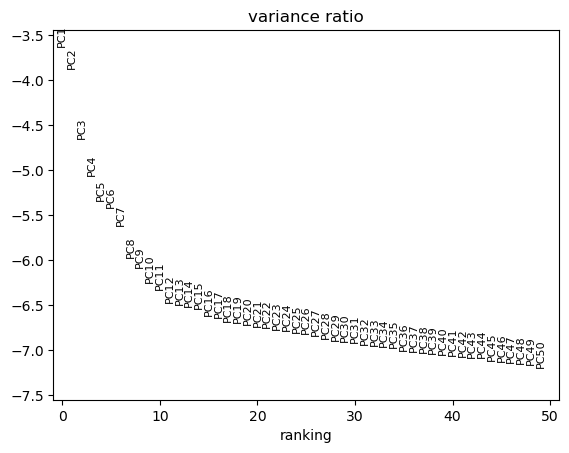

In [34]:
# run PCA
sc.pp.pca(adata, svd_solver="auto", use_highly_variable=True)
# plot single PCs to the total variance in the data
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

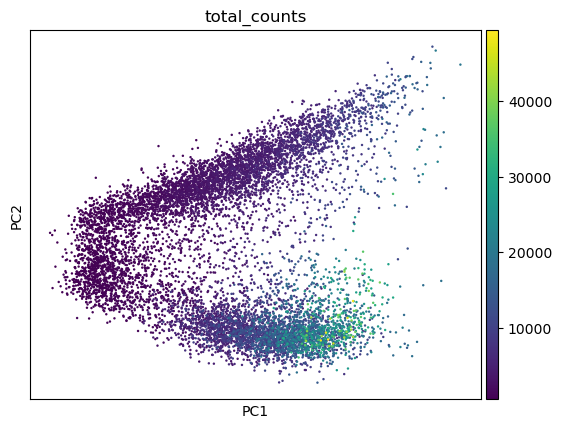

In [35]:
sc.pl.pca_scatter(adata, color="total_counts")

In [36]:
# save data
adata.write("4.PCA.h5ad")
# show AnnData
adata

AnnData object with n_obs × n_vars = 9844 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

# clustering

In [37]:
# read in data
adata = sc.read('./4.PCA.h5ad')
adata

AnnData object with n_obs × n_vars = 9844 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## plot UMAP

/public21/home/sc90258/miniconda3/envs/hy-scanpy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_14356/2706160960.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


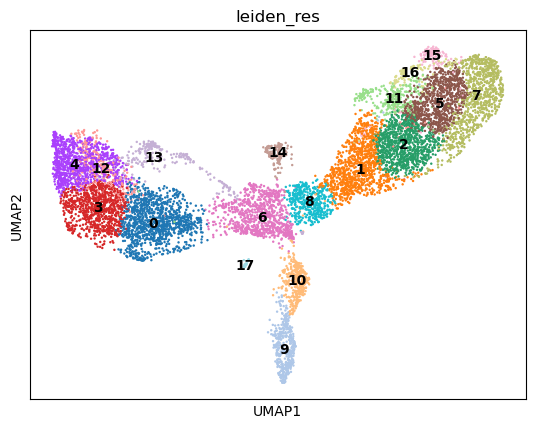

In [38]:
adata = sc.pp.neighbors(adata, n_neighbors=50, n_pcs=30, copy=True)
sc.tl.umap(
    adata, 
    min_dist=0.3
)
sc.tl.leiden(
    adata, 
    key_added="leiden_res", 
    resolution=1.2,
)
sc.pl.umap(
    adata,
    color=["leiden_res"],
    legend_loc="on data",
)

In [39]:
adata.obs['leiden_res'].value_counts()

leiden_res
0     1156
1     1018
2      941
3      906
4      897
5      845
6      830
7      823
8      431
9      426
10     359
11     291
12     283
13     253
14     140
15     112
16      99
17      34
Name: count, dtype: int64

In [40]:
# save data
adata.write("5.cluster.h5ad")
# show AnnData
adata

AnnData object with n_obs × n_vars = 9844 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier', 'leiden_res'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden_res', 'leiden_res_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Annotation

In [2]:
# read in data
adata = sc.read('./5.cluster.h5ad')
adata

AnnData object with n_obs × n_vars = 9844 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier', 'leiden_res'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden_res', 'leiden_res_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
var_to_add = ['Ctri09956', 'LOC5565599', 'LOC5573874', 'LOC5563695']
obs_to_add = ['EE-2', 'EE-3', 'EE-4', 'FBC', 'HC', 'ISC/EB']

var_new_dt = scipy.sparse.csr_matrix(
    np.zeros(
        (adata.n_obs, len(var_to_add))
    )
)
obs_new_dt = scipy.sparse.csr_matrix(
    np.zeros(
        (len(obs_to_add), adata.raw.n_vars + len(var_to_add))
    )
)

var_new = pd.DataFrame(index=list(adata.raw.var_names) + var_to_add)
obs_new = pd.concat([adata.obs[['leiden_res']], pd.DataFrame(obs_to_add, index=obs_to_add, columns=['leiden_res'])])

new_X = hstack([adata.raw.X, var_new_dt], format="csr")
new_X = vstack([new_X, obs_new_dt], format='csr')

adata_plt = ad.AnnData(
    X=new_X,
    obs=obs_new,
    var=var_new,
)
adata_plt

AnnData object with n_obs × n_vars = 9850 × 19677
    obs: 'leiden_res'

In [4]:
adata = adata_plt

## make marker genes dict (Culex pipiens pallens)

In [5]:
aae_homo = pd.read_csv('/public21/home/sc90258/huangying/analysis/12.pan_mosquito/20240830_homo_gene/cxpip_aae.homog.csv')
aae_homo

,cxpip,aae
0,ND1,CFI06_mgp01
1,CYTB,CFI06_mgp02
2,ND6,CFI06_mgp03
3,ND4L,CFI06_mgp04
4,ND4,CFI06_mgp05
...,...,...
10669,LOC120419195,LOC5580327
10670,LOC120415473,LOC5580328
10671,LOC120419194,LOC5580329
10672,LOC120422788,LOC5580330


In [6]:
marker_genes_raw = {
    'ISC/EB': ['LOC5563695', 'LOC5578162', 'LOC5580156', 'LOC5570443', 'LOC110676293', 'LOC5580247'], # fibulin-1, Klu, Delta, esg
    'Cardia': ['LOC5564993', 'LOC5572257', 'LOC5579458'], # GAM1, chymotrypsin-2, LYZ1 , ['LOC5568253', 'LOC5572257'] FCN3, CTRB2
    'EC': ['LOC23687865', 'LOC5573855', 'LOC110676249'], # Nub, CPA-VII, CG1139
    'EC-like': ['LOC5571803', 'LOC5574806', 'LOC5572376', 'Ctri09956', 'LOC5579996', 'LOC5570613'], # CAH7, Cht10, BTBD3, KLK7, MAP7, SNAT1, LYZL
    'EE': ['LOC5575988', 'LOC5569132', 'LOC5575886', 'LOC5573874', 'LOC5565599', 'LOC5573386', 'LOC5571151', 'LOC5568255'], # prospero, npf, orcokinin, Calexcitin-1, SCG5, CABP, FGB/G
    'VM':['LOC5571832'], # actin
    'FBC':['LOC5571084'], # apolipophorin-3
    'HC':['LOC5570883', 'LOC110674010'], # LRIM16, NimB2
}

In [7]:
mg_homo = []
for k, v in marker_genes_raw.items():
    print(f'{k}:')
    for g in v:
        res = aae_homo[aae_homo['aae'] == g]
        if res.empty:
            print(f'{g}: NA')
        else:
            print(res)
            mg_homo.append(res)
mg_homo = pd.concat(mg_homo, axis=0)
mg_homo = dict(mg_homo.iloc[:, [1,0]].values)
mg_homo

ISC/EB:
LOC5563695: NA
             cxpip         aae
9654  LOC120420813  LOC5578162
              cxpip         aae
10565  LOC120417918  LOC5580156
             cxpip         aae
5196  LOC120429678  LOC5570443
            cxpip           aae
383  LOC120418999  LOC110676293
              cxpip         aae
10623  LOC120422198  LOC5580247
Cardia:
             cxpip         aae
2137  LOC120425153  LOC5564993
             cxpip         aae
6291  LOC120421359  LOC5572257
              cxpip         aae
10299  LOC120422630  LOC5579458
EC:
LOC23687865: NA
LOC5573855: NA
            cxpip           aae
372  LOC120412616  LOC110676249
EC-like:
             cxpip         aae
6025  LOC120420175  LOC5571803
             cxpip         aae
7791  LOC120426794  LOC5574806
             cxpip         aae
6358  LOC120422011  LOC5572376
Ctri09956: NA
              cxpip         aae
10483  LOC120412890  LOC5579996
             cxpip         aae
5288  LOC120424932  LOC5570613
EE:
             cxpip         

{'LOC5578162': 'LOC120420813',
 'LOC5580156': 'LOC120417918',
 'LOC5570443': 'LOC120429678',
 'LOC110676293': 'LOC120418999',
 'LOC5580247': 'LOC120422198',
 'LOC5564993': 'LOC120425153',
 'LOC5572257': 'LOC120421359',
 'LOC5579458': 'LOC120422630',
 'LOC110676249': 'LOC120412616',
 'LOC5571803': 'LOC120420175',
 'LOC5574806': 'LOC120426794',
 'LOC5572376': 'LOC120422011',
 'LOC5579996': 'LOC120412890',
 'LOC5570613': 'LOC120424932',
 'LOC5575988': 'LOC120423418',
 'LOC5569132': 'LOC120429116',
 'LOC5573386': 'LOC120415972',
 'LOC5571151': 'LOC120414678',
 'LOC5568255': 'LOC120424080',
 'LOC5571832': 'LOC120429254',
 'LOC5571084': 'LOC120414845',
 'LOC5570883': 'LOC120421492',
 'LOC110674010': 'LOC120415515'}

In [8]:
mg_homo.update(
    {
        'LOC23687865': 'LOC120427085', # Nub
        'LOC5573855': 'LOC120428198', # CPA-VII
        'LOC5575886': 'LOC120415737', # npf
        'LOC110676249': 'LOC120412616', # CG1139
        'LOC5572376': 'LOC120412869', # BTBD3
    }
)
mg_homo

{'LOC5578162': 'LOC120420813',
 'LOC5580156': 'LOC120417918',
 'LOC5570443': 'LOC120429678',
 'LOC110676293': 'LOC120418999',
 'LOC5580247': 'LOC120422198',
 'LOC5564993': 'LOC120425153',
 'LOC5572257': 'LOC120421359',
 'LOC5579458': 'LOC120422630',
 'LOC110676249': 'LOC120412616',
 'LOC5571803': 'LOC120420175',
 'LOC5574806': 'LOC120426794',
 'LOC5572376': 'LOC120412869',
 'LOC5579996': 'LOC120412890',
 'LOC5570613': 'LOC120424932',
 'LOC5575988': 'LOC120423418',
 'LOC5569132': 'LOC120429116',
 'LOC5573386': 'LOC120415972',
 'LOC5571151': 'LOC120414678',
 'LOC5568255': 'LOC120424080',
 'LOC5571832': 'LOC120429254',
 'LOC5571084': 'LOC120414845',
 'LOC5570883': 'LOC120421492',
 'LOC110674010': 'LOC120415515',
 'LOC23687865': 'LOC120427085',
 'LOC5573855': 'LOC120428198',
 'LOC5575886': 'LOC120415737'}

In [9]:
marker_genes = {}
for k, v in marker_genes_raw.items():
    marker_genes[k] = [mg_homo[i] if i in mg_homo.keys() else i for i in v ]
marker_genes

{'ISC/EB': ['LOC5563695',
  'LOC120420813',
  'LOC120417918',
  'LOC120429678',
  'LOC120418999',
  'LOC120422198'],
 'Cardia': ['LOC120425153', 'LOC120421359', 'LOC120422630'],
 'EC': ['LOC120427085', 'LOC120428198', 'LOC120412616'],
 'EC-like': ['LOC120420175',
  'LOC120426794',
  'LOC120412869',
  'Ctri09956',
  'LOC120412890',
  'LOC120424932'],
 'EE': ['LOC120423418',
  'LOC120429116',
  'LOC120415737',
  'LOC5573874',
  'LOC5565599',
  'LOC120415972',
  'LOC120414678',
  'LOC120424080'],
 'VM': ['LOC120429254'],
 'FBC': ['LOC120414845'],
 'HC': ['LOC120421492', 'LOC120415515']}

In [10]:
def fmt_k(x):
    if x in mg_homo.keys():
        return mg_homo[x]
    else:
        return x

g_n = {fmt_k(k): v \
    for k, v in zip(['LOC5563695', 'LOC5578162', 'LOC5580156', 'LOC5570443', 'LOC5564993', 'LOC5579458', 'LOC23687865', 'LOC5573855', 'LOC5571803', 'LOC5574806', 'LOC5570613', 'LOC110676293', 'LOC5575988', 'LOC5575886', 'LOC5569132', 'LOC5573874', 'LOC5571832', 'LOC5571084', 'LOC5570883', 'LOC110674010', 'LOC5580247', 'LOC5565599', 'LOC110676249', 'LOC5572376', 'LOC5572257', 'Ctri09956', 'LOC5579996', 'LOC5573386', 'LOC5571151', 'LOC5568255'],
    ['fibulin-1', 'Klu', 'Delta', 'esg', 'GAM1', 'LYSC', 'Nubbin', 'CPA-VII', 'CAH7', 'Cht10', 'NAAT', 'LYSC11', 'prospero', 'npf', 'orcokinin', 'Calexcitin-1', 'actin', 'apolipophorin-3', 'LRIM16', 'NimB2', 'PCNA', 'CCHa2', 'CG1139', 'BTBD3', 'chymotrypsin-2', 'KLK7', 'MAP7', 'SCG5', 'CABP', 'FGB/G'])
}
g_n

{'LOC5563695': 'fibulin-1',
 'LOC120420813': 'Klu',
 'LOC120417918': 'Delta',
 'LOC120429678': 'esg',
 'LOC120425153': 'GAM1',
 'LOC120422630': 'LYSC',
 'LOC120427085': 'Nubbin',
 'LOC120428198': 'CPA-VII',
 'LOC120420175': 'CAH7',
 'LOC120426794': 'Cht10',
 'LOC120424932': 'NAAT',
 'LOC120418999': 'LYSC11',
 'LOC120423418': 'prospero',
 'LOC120415737': 'npf',
 'LOC120429116': 'orcokinin',
 'LOC5573874': 'Calexcitin-1',
 'LOC120429254': 'actin',
 'LOC120414845': 'apolipophorin-3',
 'LOC120421492': 'LRIM16',
 'LOC120415515': 'NimB2',
 'LOC120422198': 'PCNA',
 'LOC5565599': 'CCHa2',
 'LOC120412616': 'CG1139',
 'LOC120412869': 'BTBD3',
 'LOC120421359': 'chymotrypsin-2',
 'Ctri09956': 'KLK7',
 'LOC120412890': 'MAP7',
 'LOC120415972': 'SCG5',
 'LOC120414678': 'CABP',
 'LOC120424080': 'FGB/G'}

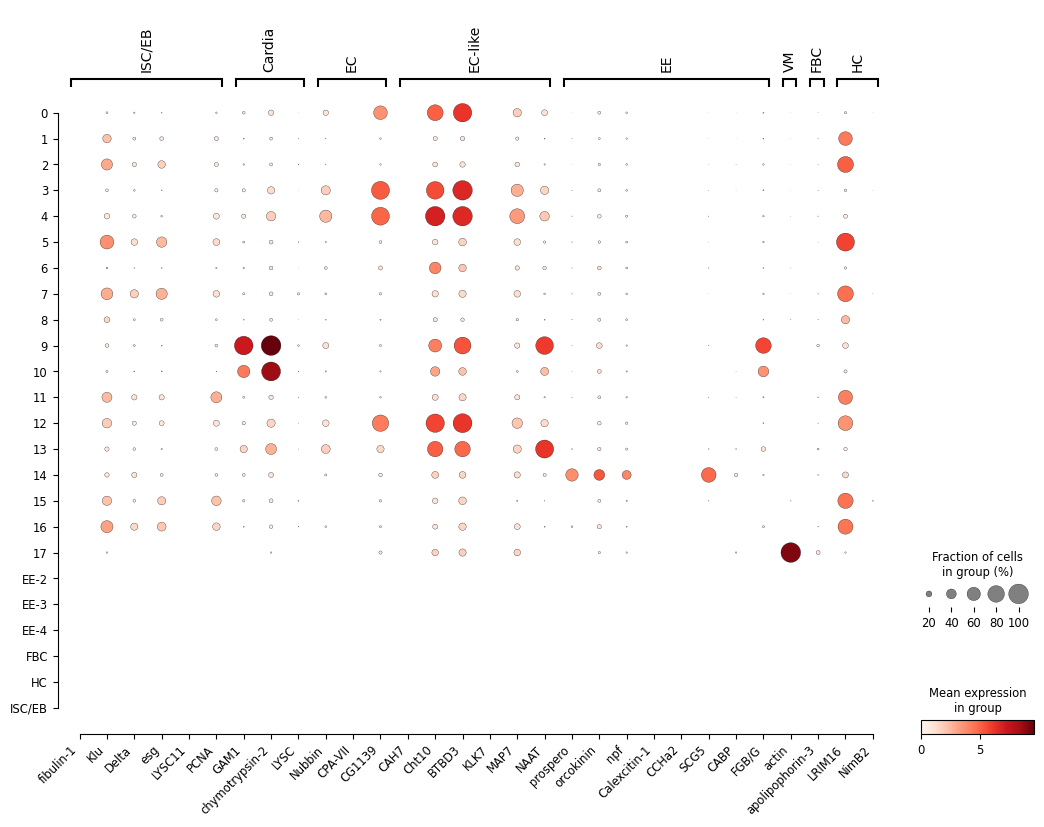

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sc.pl.dotplot(
    adata,
    var_names=marker_genes,
    # category_order=adata_plt.obs['order'],
    groupby='leiden_res',
    dendrogram=False,
    # log=True,
    # vmax=5,
    show=False,
)

axm = ax['mainplot_ax']

axm.set_xticklabels(
    [g_n[i.get_text()] for i in axm.get_xticklabels()],
    rotation=45, ha='right')
# axm.set_yticklabels(marker_genes.keys())

sns.despine(top=True, right=True, trim=1, ax=axm)

In [11]:
n_id = {
    'ISC/EB': ['5', '7'],
    'ISC/EB-prol': ['15', '16', '11'],
    'EB': ['1', '2'],
    'Cardia-1': ['9'],
    'Cardia-2': ['10'],
    'EC': ['3', '4', '12'],
    'EC-like-1': ['0'],
    'EC-like-2': ['6'],
    'EC-like-3': ['13'],
    'EE-1': ['14'],
    'EE-2': ['EE-2'],
    'EE-3': ['EE-3'],
    'VM': ['17'],
    'FBC': ['FBC'],
    'HC': ['HC'],
}

In [12]:
id_n = {}
for k, v in n_id.items():
    for i in v:
        id_n[i] = k

id_n

{'5': 'ISC/EB',
 '7': 'ISC/EB',
 '15': 'ISC/EB-prol',
 '16': 'ISC/EB-prol',
 '11': 'ISC/EB-prol',
 '1': 'EB',
 '2': 'EB',
 '9': 'Cardia-1',
 '10': 'Cardia-2',
 '3': 'EC',
 '4': 'EC',
 '12': 'EC',
 '0': 'EC-like-1',
 '6': 'EC-like-2',
 '13': 'EC-like-3',
 '14': 'EE-1',
 'EE-2': 'EE-2',
 'EE-3': 'EE-3',
 '17': 'VM',
 'FBC': 'FBC',
 'HC': 'HC'}

In [13]:
adata.obs['cluster'] = adata.obs['leiden_res'].map(
    lambda x: id_n[x] if x in id_n.keys() else x)

In [14]:
adata.obs['cluster'].unique()

array(['EB', 'ISC/EB-prol', 'Cardia-2', 'EC-like-3', 'EC-like-2', 'EC',
       '8', 'EC-like-1', 'Cardia-1', 'ISC/EB', 'VM', 'EE-1', 'EE-2',
       'EE-3', 'EE-4', 'FBC', 'HC'], dtype=object)

In [15]:
list(n_id.keys())

['ISC/EB',
 'ISC/EB-prol',
 'EB',
 'Cardia-1',
 'Cardia-2',
 'EC',
 'EC-like-1',
 'EC-like-2',
 'EC-like-3',
 'EE-1',
 'EE-2',
 'EE-3',
 'VM',
 'FBC',
 'HC']

In [16]:
adata.obs['cluster_name'] = adata.obs['cluster']
adata.obs['cluster_name'] = adata.obs['cluster_name'].astype('category')
adata.obs['cluster_name'] = adata.obs[
        'cluster_name'
    ].cat.reorder_categories(list(n_id.keys()) + ['EE-4', '8'], ordered=True)

adata.obs['cluster_name'].unique()

['EB', 'ISC/EB-prol', 'Cardia-2', 'EC-like-3', 'EC-like-2', ..., 'EE-2', 'EE-3', 'EE-4', 'FBC', 'HC']
Length: 17
Categories (17, object): ['ISC/EB' < 'ISC/EB-prol' < 'EB' < 'Cardia-1' ... 'FBC' < 'HC' < 'EE-4' < '8']

In [17]:
g_n

{'LOC5563695': 'fibulin-1',
 'LOC120420813': 'Klu',
 'LOC120417918': 'Delta',
 'LOC120429678': 'esg',
 'LOC120425153': 'GAM1',
 'LOC120422630': 'LYSC',
 'LOC120427085': 'Nubbin',
 'LOC120428198': 'CPA-VII',
 'LOC120420175': 'CAH7',
 'LOC120426794': 'Cht10',
 'LOC120424932': 'NAAT',
 'LOC120418999': 'LYSC11',
 'LOC120423418': 'prospero',
 'LOC120415737': 'npf',
 'LOC120429116': 'orcokinin',
 'LOC5573874': 'Calexcitin-1',
 'LOC120429254': 'actin',
 'LOC120414845': 'apolipophorin-3',
 'LOC120421492': 'LRIM16',
 'LOC120415515': 'NimB2',
 'LOC120422198': 'PCNA',
 'LOC5565599': 'CCHa2',
 'LOC120412616': 'CG1139',
 'LOC120412869': 'BTBD3',
 'LOC120421359': 'chymotrypsin-2',
 'Ctri09956': 'KLK7',
 'LOC120412890': 'MAP7',
 'LOC120415972': 'SCG5',
 'LOC120414678': 'CABP',
 'LOC120424080': 'FGB/G'}

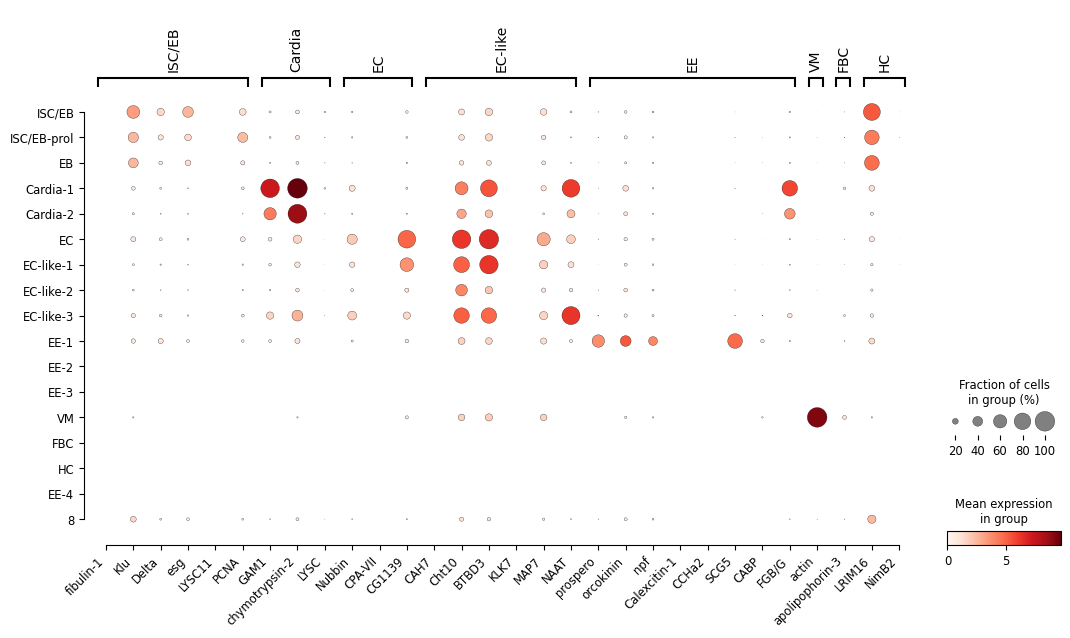

In [36]:
# save fig
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib.use('cairo')

ax = sc.pl.dotplot(
    adata,
    var_names=marker_genes,
    # category_order=adata_plt.obs['order'],
    groupby='cluster_name',
    dendrogram=False,
    # log=True,
    # vmax=5,
    show=False,
)

axm = ax['mainplot_ax']

axm.set_xticklabels(
    [g_n[i.get_text()] for i in axm.get_xticklabels()],
    rotation=45, ha='right')
# axm.set_yticklabels(marker_genes.keys())

sns.despine(top=True, right=True, trim=1, ax=axm)
# plt.savefig('aae_dotplot.pdf', bbox_inches='tight')
# plt.close()

In [66]:
sc.tl.rank_genes_groups(
    adata, 
    "cluster_name", 
    method="wilcoxon", 
    pts=True, 
    key_added='rank_genes_groups.wilcoxon'
)

In [67]:
sc.tl.filter_rank_genes_groups(
    adata,
    key="rank_genes_groups.wilcoxon",
    key_added="rank_genes_groups.wilcoxon.filter",
)

In [68]:
adata.uns['rank_genes_groups.wilcoxon']

{'params': {'groupby': 'cluster_name',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': True,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'pts':                 ISC/EB  ISC/EB-prol        EB  Cardia-1  Cardia-2        EC  \
 LOC120427725  0.007194     0.001992  0.004084  0.007042  0.002786  0.003835   
 LOC120427726  0.000000     0.000000  0.000000  0.000000  0.000000  0.000000   
 LOC128092783  0.000000     0.000000  0.000000  0.000000  0.000000  0.000000   
 LOC120427727  0.000000     0.000000  0.000000  0.000000  0.000000  0.000000   
 LOC120427724  0.001799     0.000000  0.000000  0.000000  0.000000  0.000959   
 ...                ...          ...       ...       ...       ...       ...   
 ND4           0.868106     0.872510  0.642675  0.800469  0.350975  0.900767   
 ND4L          0.181055     0.207171  0.078612  0.150235  0.016713  0.242570   
 ND6           0.760192     0.741036  0.508933  0.873239  0.381616  0.916587   
 CYTB          0.998801     0.9

In [69]:
name = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['names'])
padj = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['pvals_adj'])
lgFC = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['logfoldchanges'])
scores = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon']['scores'])
pts = adata.uns['rank_genes_groups.wilcoxon.filter']['pts']
pts_rest = adata.uns['rank_genes_groups.wilcoxon.filter']['pts_rest']

dfs = []
for cluster in name.columns:
    df = pd.concat(
        [
            name[cluster].dropna(), 
            padj[cluster].dropna(), 
            lgFC[cluster].dropna(),
            scores[cluster].dropna(),
        ], 
        axis=1
    )
    df.columns = ['names', 'pvals_adj', 'logfoldchanges', 'scores']
    df.set_index(['names'], inplace=True)

    pts_df = pd.concat([pts[[cluster]], pts_rest[[cluster]]], axis=1)
    pts_df.columns = ['pts', 'pts_rest']

    df = df.merge(pts_df, left_index=True, right_index=True, how='inner')
    df['leiden_res'] = cluster

    dfs.append(df)

markg = pd.concat(dfs, axis=0)
markg = markg.sort_values(['leiden_res', 'scores'], ascending=False)

markg

,pvals_adj,logfoldchanges,scores,pts,pts_rest,leiden_res
names,,,,,,
LOC120420715,2.636347e-20,20.950214,10.081536,1.000000,0.000815,VM
LOC120429254,2.636347e-20,20.275787,10.081536,1.000000,0.001223,VM
LOC120425115,2.636347e-20,20.354063,10.081416,1.000000,0.001631,VM
LOC120420188,2.636347e-20,19.659107,10.081174,1.000000,0.001835,VM
LOC120423829,2.636347e-20,20.095514,10.081053,1.000000,0.001427,VM
...,...,...,...,...,...,...
LOC120430683,1.395541e-02,1.102218,3.312607,0.260563,0.173179,Cardia-1
LOC120419774,1.622334e-02,1.095737,3.267873,0.258216,0.171268,Cardia-1
LOC120432139,2.048613e-02,1.001319,3.196035,0.279343,0.199724,Cardia-1


In [70]:
markg.to_csv('./5.marker_genes.csv')

In [18]:
n_id = {
    'ISC/EB': ['1', '2', '8'],
    'ISC/EB-prol': ['15', '16', '11', '5', '7'],
    'Cardia-1': ['9'],
    'Cardia-2': ['10'],
    'EC': ['3', '4', '12'],
    'EC-like-1': ['0'],
    'EC-like-2': ['6'],
    'EC-like-3': ['13'],
    'EE-1': ['14'],
    'EE-2': ['EE-2'],
    'EE-3': ['EE-3'],
    'EE-4': ['EE-4'],
    'VM': ['17'],
    'FBC': ['FBC'],
    'HC': ['HC'],
}

In [19]:
id_n = {}
for k, v in n_id.items():
    for i in v:
        id_n[i] = k

id_n

{'1': 'ISC/EB',
 '2': 'ISC/EB',
 '8': 'ISC/EB',
 '15': 'ISC/EB-prol',
 '16': 'ISC/EB-prol',
 '11': 'ISC/EB-prol',
 '5': 'ISC/EB-prol',
 '7': 'ISC/EB-prol',
 '9': 'Cardia-1',
 '10': 'Cardia-2',
 '3': 'EC',
 '4': 'EC',
 '12': 'EC',
 '0': 'EC-like-1',
 '6': 'EC-like-2',
 '13': 'EC-like-3',
 '14': 'EE-1',
 'EE-2': 'EE-2',
 'EE-3': 'EE-3',
 'EE-4': 'EE-4',
 '17': 'VM',
 'FBC': 'FBC',
 'HC': 'HC'}

In [20]:
adata.obs['cluster'] = adata.obs['leiden_res'].map(
    lambda x: id_n[x] if x in id_n.keys() else x)

In [21]:
adata.obs['cluster'].unique()

array(['ISC/EB', 'ISC/EB-prol', 'Cardia-2', 'EC-like-3', 'EC-like-2',
       'EC', 'EC-like-1', 'Cardia-1', 'VM', 'EE-1', 'EE-2', 'EE-3',
       'EE-4', 'FBC', 'HC'], dtype=object)

In [22]:
adata.obs['cluster_name'] = adata.obs['cluster']
adata.obs['cluster_name'] = adata.obs['cluster_name'].astype('category')
adata.obs['cluster_name'] = adata.obs[
        'cluster_name'
    ].cat.reorder_categories(list(n_id.keys()), ordered=True)

adata.obs['cluster_name'].unique()

['ISC/EB', 'ISC/EB-prol', 'Cardia-2', 'EC-like-3', 'EC-like-2', ..., 'EE-2', 'EE-3', 'EE-4', 'FBC', 'HC']
Length: 15
Categories (15, object): ['ISC/EB' < 'ISC/EB-prol' < 'Cardia-1' < 'Cardia-2' ... 'EE-4' < 'VM' < 'FBC' < 'HC']

In [23]:
dp = sc.pl.dotplot(
    adata,
    var_names=marker_genes,
    # category_order=adata_plt.obs['order'],
    groupby='cluster_name',
    dendrogram=False,
    # log=True,
    # vmax=5,
    show=False,
    return_fig=True,
)

dp.dot_color_df.to_csv('./5.dot_color_df.cxpip.csv')
dp.dot_size_df.to_csv('./5.dot_size_df.cxpip.csv')

In [25]:
dp.dot_color_df.index.unique()

CategoricalIndex(['ISC/EB', 'ISC/EB-prol', 'Cardia-1', 'Cardia-2', 'EC',
                  'EC-like-1', 'EC-like-2', 'EC-like-3', 'EE-1', 'EE-2',
                  'EE-3', 'EE-4', 'VM', 'FBC', 'HC'],
                 categories=['ISC/EB', 'ISC/EB-prol', 'Cardia-1', 'Cardia-2', ..., 'EE-4', 'VM', 'FBC', 'HC'], ordered=True, dtype='category')

In [42]:
# save fig
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.use('cairo')

ax = sc.pl.dotplot(
    adata,
    var_names=marker_genes,
    # category_order=adata_plt.obs['order'],
    groupby='cluster_name',
    dendrogram=False,
    # log=True,
    # vmax=5,
    show=False,
)

axm = ax['mainplot_ax']

axm.set_xticklabels(
    [g_n[i.get_text()] for i in axm.get_xticklabels()],
    rotation=45, ha='right', fontweight='bold')
axm.set_yticklabels(
    [i.get_text() for i in axm.get_yticklabels()],
    fontweight='bold')
# axm.set_yticklabels(marker_genes.keys())

sns.despine(top=True, right=True, trim=1, ax=axm)
plt.savefig('cxpip_dotplot.pdf', bbox_inches='tight')
plt.close()

In [22]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns

matplotlib.use('cairo')

fig, ax = plt.subplots(figsize=(8, 6))

# c = sns.color_palette('deep')
# set1 = sns.color_palette('Set1')
# set2 = sns.color_palette('Set2')
# def get_c(lst):
#     rc = ["#a4cde1","#67a4cc","#277fb8","#549da3","#96cb8f","#8bc96d","#4dae47","#5c9e43","#b79973","#f38989","#ec5051","#e32427","#ef6a45","#f9b769","#f9a341","#f48521","#ee8e46","#d4a6a8","#af93c4","#8660a8","#815e99","#c6b598","#f6f28f","#d4a55b","#b05a28"]
#     c = []
#     for i in lst:
#         c.append(rc[i])
#     return c.copy()
c = ["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD",
    "#8C564B", "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF",
    "#FFD700", "#8B008B", "#FF4500"] # "#00CED1", 'FBC', 
cells = ['ISC/EB', 'ISC/EB-prol', 'Cardia-1', 'Cardia-2', 'EC', 'EC-like-1', 'EC-like-2', 'EC-like-3', 'EE-1', 'EE-2', 'EE-3', 'VM', 'HC']

umap = pd.DataFrame(
    adata.obsm['X_umap'], 
    columns=['umap1', 'umap2'],
    index=adata.obs.index
)

grp_color = {k:v for k, v in zip(cells, c)}

for lb in n_id.keys():
    pdf = umap[adata.obs['cluster_name'] == lb]
    l1, = ax.plot(
        pdf['umap1'], pdf['umap2'], '.', color=grp_color[lb],
        alpha=0.6, ms=1.5, clip_on = False)

x = 2.5; y = -1

ax.arrow(
    x-6.5, y-3, 0, 2.2, 
    width=0.01, head_width=0.2, overhang=0.3, 
    color='k', zorder=10)
ax.arrow(
    x-6.5, y-3, 3, 0, 
    width=0.01, head_width=0.2, overhang=0.3,
    color='k', zorder=10)

ax.set_axis_off()

ax.text(x-4.8, y-3.1, 'UMAP-1', ha='center', va='top')
ax.text(x-6.5, y-2, 'UMAP-2', ha='right', va='center', rotation=90)

for i, (cell, color) in enumerate(grp_color.items()):
    x = 8; y = 0
    sep = 7
    j = i // sep

    ax.plot(x + j * 6, y - (i % sep) * 0.6, '.', color=color, mec=color, ms=11, alpha=0.9, clip_on = False)
    ax.text(x + j * 6 + 0.5, y - (i % sep) * 0.6, 
    f'{cell}: {len(adata.obs[adata.obs["cluster_name"] == cell])}', 
    ha='left', va='center', clip_on = False, fontsize=10)

# plt.savefig('./plots/f2.clust.umap_merge.png', dpi=600, bbox_inches='tight')
plt.savefig('cxpip_umap.pdf', bbox_inches='tight')
plt.close()

In [23]:
adata.write('./6.ann.h5ad')

In [2]:
adata = sc.read('./6.ann.h5ad')

sc.tl.rank_genes_groups(
    adata, 
    "cluster_name", 
    method="wilcoxon", 
    pts=True, 
    key_added='rank_genes_groups.wilcoxon'
)

sc.tl.filter_rank_genes_groups(
    adata,
    key="rank_genes_groups.wilcoxon",
    key_added="rank_genes_groups.wilcoxon.filter",
)

name = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['names'])
padj = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['pvals_adj'])
lgFC = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['logfoldchanges'])
scores = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon']['scores'])
pts = adata.uns['rank_genes_groups.wilcoxon.filter']['pts']
pts_rest = adata.uns['rank_genes_groups.wilcoxon.filter']['pts_rest']

dfs = []
for cluster in name.columns:
    df = pd.concat(
        [
            name[cluster].dropna(), 
            padj[cluster].dropna(), 
            lgFC[cluster].dropna(),
            scores[cluster].dropna(),
        ], 
        axis=1
    )
    df.columns = ['names', 'pvals_adj', 'logfoldchanges', 'scores']
    df.set_index(['names'], inplace=True)

    pts_df = pd.concat([pts[[cluster]], pts_rest[[cluster]]], axis=1)
    pts_df.columns = ['pts', 'pts_rest']

    df = df.merge(pts_df, left_index=True, right_index=True, how='inner')
    df['leiden_res'] = cluster

    dfs.append(df)

markg = pd.concat(dfs, axis=0)
markg = markg.sort_values(['leiden_res', 'scores'], ascending=False)

markg.to_csv('./6.marker_genes.cxpip.csv')

In [2]:
adata = sc.read('./6.ann.h5ad')

# write umap plot data
umap = pd.DataFrame(
    adata.obsm['X_umap'], 
    columns=['umap1', 'umap2'],
    index=adata.obs.index
)

umap_lb = pd.concat([umap, adata.obs[['cluster_name']]], axis=1)
umap_lb.index.name = 'barcode'

umap_lb.to_csv('6.umap_lb.cxpip.csv')